In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso, SGDRegressor
from sklearn.metrics import  make_scorer,  mean_squared_error
%matplotlib inline
from scipy.stats import skew, skewtest, norm
from xgboost.sklearn import XGBRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [60]:
from catboost import Pool, CatBoostRegressor


In [62]:
from scipy.stats import skew, skewtest, norm

In [64]:
import seaborn as sns

In [65]:
data = pd.read_csv('ml_eng_ay_data.csv')

In [66]:
data.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city,geo_city_part
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,NaN,f,t,t,t,f,hamburg,wandsbek
1,2018-09-15,2,70.00,1100.0,1280.0,appartment,average,good,60+,NaN,t,t,f,t,f,hamburg,mitte
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,NaN,t,t,f,t,t,hamburg,altona
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,f,t,f,t,t,hamburg,wandsbek
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,NaN,f,t,f,t,f,hamburg,hamburg-nord


In [67]:
# data['log_rent_total'] = np.log1p(data.rent_total)

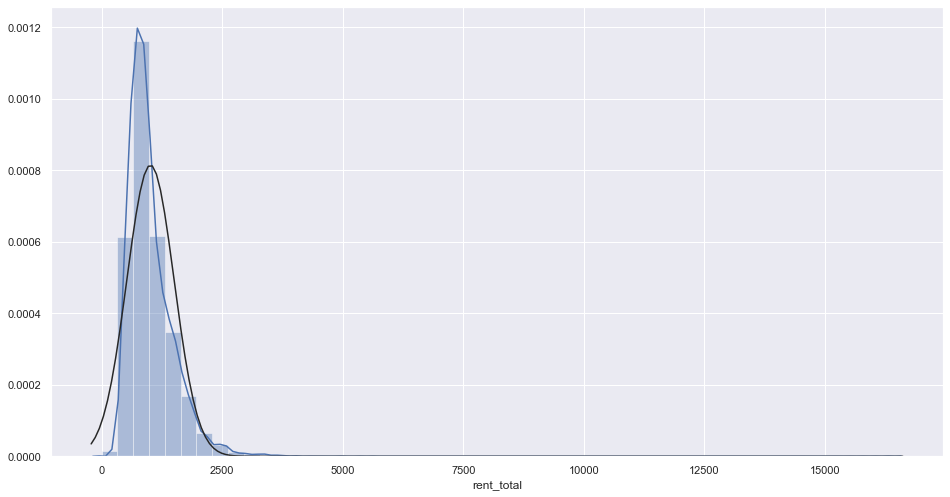

In [68]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(data['rent_total'], fit=norm)

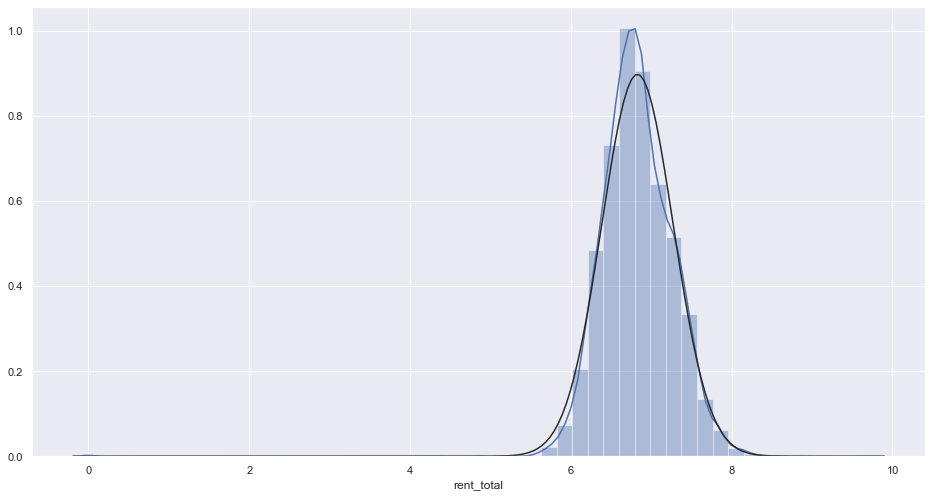

In [70]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(np.log1p(data['rent_total']), fit=norm)

In [71]:
print("Skewness: %f" % data['rent_total'].skew())
print("Kurtosis: %f" % data['rent_total'].kurt())

Skewness: 3.801670
Kurtosis: 72.219517


## Looking for outliers

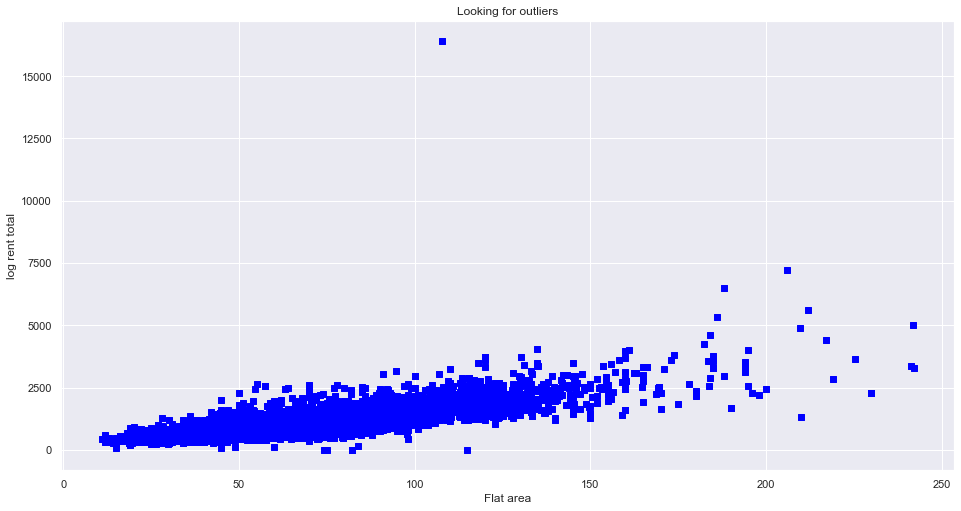

In [103]:
plt.scatter(data.flat_area, data.rent_total, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("Flat area")
plt.ylabel("rent total")
plt.show()

In [104]:
data.flat_age.unique()

array(['60+', '<5', '<30', '<40', '<60', '<10', '<50', '<20', '<1'],
      dtype=object)

In [105]:
# you have some mistake in label :)

In [106]:
data.flat_type.replace("appartment", "apartment", inplace=True)

In [107]:
data.head()

,date,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,...,has_garden,has_kitchen,has_guesttoilet,geo_city,geo_city_part,weekday,weekofyear,month,is_weekend,season
0,2018-09-15,1,36.00,530.0,650.0,apartment,average,good,60+,138.3,...,t,t,f,hamburg,wandsbek,5,37,9,True,4
1,2018-09-15,2,70.00,1100.0,1280.0,apartment,average,good,60+,138.3,...,f,t,f,hamburg,mitte,5,37,9,True,4
2,2018-09-15,2,62.13,1040.0,1220.0,apartment,sophisticated,first_time_use,<5,50.7,...,f,t,t,hamburg,altona,5,37,9,True,4
3,2018-09-15,2,75.00,675.0,950.0,roof_storey,average,good,<30,104.0,...,f,t,t,hamburg,wandsbek,5,37,9,True,4
4,2018-09-15,2,52.00,676.0,810.0,apartment,average,good,60+,138.3,...,f,t,f,hamburg,hamburg-nord,5,37,9,True,4


## Feature engineering
#### I add some new features based on our data:
* price per meter
* mean price per meter in city_part
* median  base price per meter in city_part
* median base price in this ditrisct
* median base price of cnt_room 
* is_holiday
* day_of_week
* month
* season 
* mean room ploshad
* 

In [108]:
data[['flat_thermal_characteristic', 'flat_age']].groupby('flat_age').median()

,flat_thermal_characteristic
flat_age,
60+,138.3
<1,57.0
<10,56.0
<20,76.0
<30,104.2
<40,131.7
<5,50.7
<50,135.0
<60,132.0


In [109]:
data['flat_thermal_characteristic'] = data[['flat_thermal_characteristic', 'flat_age']].groupby('flat_age').transform(lambda x: x.fillna(x.median()))

In [110]:
data.loc[data.index == 14957]['flat_age']

14957    <20
Name: flat_age, dtype: object

In [111]:
data['price_per_meter'] = data['rent_base'] / data['flat_area']

In [112]:
data[['price_per_meter', 'geo_city_part']].groupby('geo_city_part').mean()

,price_per_meter
geo_city_part,
altona,13.279246
bergedorf,10.618042
eimsbuettel,13.398530
hamburg-nord,13.701492
harburg,9.480297
mitte,12.958914
wandsbek,11.218225


In [113]:
data.groupby('geo_city_part').mean()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city_part,,,,,,,,,,,
altona,2.567568,70.803360,940.781876,1141.584701,118.133651,2.558559,25.730790,6.325384,0.139375,2.499205,13.279246
bergedorf,2.587855,68.680504,731.367119,913.678811,109.076770,2.263566,26.227390,6.425065,0.091731,2.554264,10.618042
eimsbuettel,2.415725,66.593189,879.969574,1062.897550,119.877880,2.472198,25.826672,6.341877,0.124674,2.533449,13.398530
hamburg-nord,2.409077,65.316109,890.119940,1067.480116,122.056327,2.511197,24.782323,6.119140,0.132278,2.479546,13.701492
harburg,2.534676,65.154027,607.593244,773.307248,122.577681,2.306488,25.437733,6.238628,0.095451,2.512304,9.480297
mitte,2.409170,65.188542,850.430536,1036.995532,120.545852,2.494810,25.578720,6.281142,0.122837,2.515571,12.958914
wandsbek,2.522871,68.808147,765.197589,956.984551,119.391569,2.400334,25.070785,6.164942,0.108180,2.464441,11.218225


In [114]:
data.groupby('geo_city_part').median()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city_part,,,,,,,,,,,
altona,3,68.00,859.00,1032.480,131.7,3,25,6,False,2,13.461538
bergedorf,3,67.00,700.70,870.175,99.5,2,26,6,False,3,10.833333
eimsbuettel,2,63.31,775.00,947.010,131.7,2,26,6,False,3,12.968296
hamburg-nord,2,61.00,795.00,950.000,134.0,2,24,6,False,2,13.416936
harburg,3,64.00,542.32,698.000,132.0,2,25,6,False,3,9.073359
mitte,2,61.00,709.50,880.000,131.7,2,25,6,False,2,12.483750
wandsbek,3,67.00,705.00,882.000,128.0,2,24,6,False,2,10.921080


In [115]:
data.groupby('geo_city').mean()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city,,,,,,,,,,,
hamburg,2.473396,67.043695,830.266037,1014.962983,119.834597,2.455281,25.377005,6.240174,0.120321,2.499666,12.451784


In [116]:
data.groupby('geo_city').median()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic,weekday,weekofyear,month,is_weekend,season,price_per_meter
geo_city,,,,,,,,,,,
hamburg,2,64.0,733.48,899.025,131.7,2,25,6,False,2,12.0


In [117]:
data['diff_rent_base_and_median_on_city'] = data['rent_base'] - data.groupby('geo_city')['rent_base'].transform('median')
data['diff_rent_base_and_median_on_city_part'] = data['rent_base'] - data.groupby('geo_city_part')['rent_base'].transform('median')

data['diff_rent_base_and_mean_on_city'] = data['rent_base'] - data.groupby('geo_city')['rent_base'].transform('mean')
data['diff_rent_base_and_mean_on_city_part'] = data['rent_base'] - data.groupby('geo_city_part')['rent_base'].transform('mean')

In [121]:
data['diff_price_per_meter_and_median_on_city'] = data['price_per_meter'] - data.groupby('geo_city')['price_per_meter'].transform('median')
data['diff_price_per_meter_and_median_on_city_part'] = data['price_per_meter'] - data.groupby('geo_city_part')['price_per_meter'].transform('median')

data['diff_price_per_meter_and_mean_on_city'] = data['price_per_meter'] - data.groupby('geo_city')['price_per_meter'].transform('mean')
data['diff_price_per_meter_and_mean_on_city_part'] = data['price_per_meter'] - data.groupby('geo_city_part')['price_per_meter'].transform('mean')


In [122]:
data['date'] = pd.to_datetime(data.date)

data['weekday'] = data.date.dt.weekday
data['weekofyear'] = data.date.dt.weekofyear
data['month'] = data.date.dt.month
data['is_weekend'] = data.weekday.isin((5,6))
data['season'] = data.month.apply(lambda dt: (dt %12 + 3)//3)

In [125]:
data.columns

Index(['date', 'cnt_rooms', 'flat_area', 'rent_base', 'rent_total',
       'flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
       'flat_thermal_characteristic', 'has_elevator', 'has_balcony',
       'has_garden', 'has_kitchen', 'has_guesttoilet', 'geo_city',
       'geo_city_part', 'weekday', 'weekofyear', 'month', 'is_weekend',
       'season', 'price_per_meter', 'diff_rent_base_and_median_on_city',
       'diff_rent_base_and_median_on_city_part',
       'diff_rent_base_and_mean_on_city',
       'diff_rent_base_and_mean_on_city_part',
       'diff_price_per_meter_and_median_on_city',
       'diff_price_per_meter_and_median_on_city_part',
       'diff_price_per_meter_and_mean_on_city',
       'diff_price_per_meter_and_mean_on_city_part'],
      dtype='object')

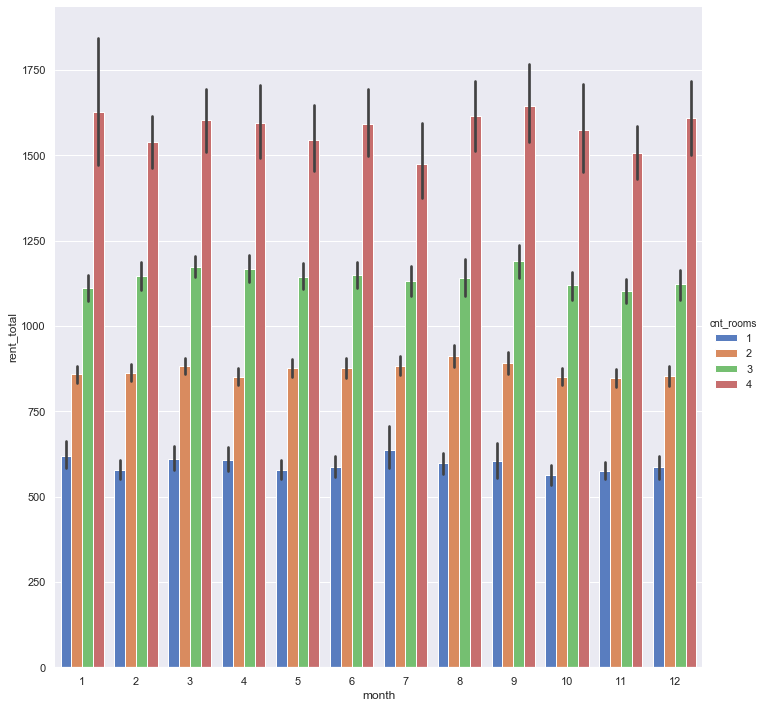

In [173]:
g = sns.catplot(x="month", y="rent_total", hue="cnt_rooms", data=data, height=10, kind='bar', palette='muted')
g.despine(left=True)

g.set_ylabels("rent_total")

## we can see that prices are independent of the season (lol)

In [127]:
CATEGORIAL_FEATURES = [
       'flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
    'has_elevator', 'has_balcony',
       'has_garden', 'has_kitchen', 'has_guesttoilet', 'geo_city',
       'geo_city_part', 'is_weekend']

In [128]:
from sklearn.preprocessing import LabelEncoder

In [129]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [147]:
le = MultiColumnLabelEncoder(columns=CATEGORIAL_FEATURES)

In [148]:
prepared_df = le.fit_transform(data)

In [149]:
y = data.rent_total

In [150]:
prepared_df.drop(['date', 'rent_total', 'geo_city'], axis=1, inplace=True)

In [134]:
# prepared_df['rent_base'] = np.log1p(prepared_df.rent_base)

## Check feature correlation

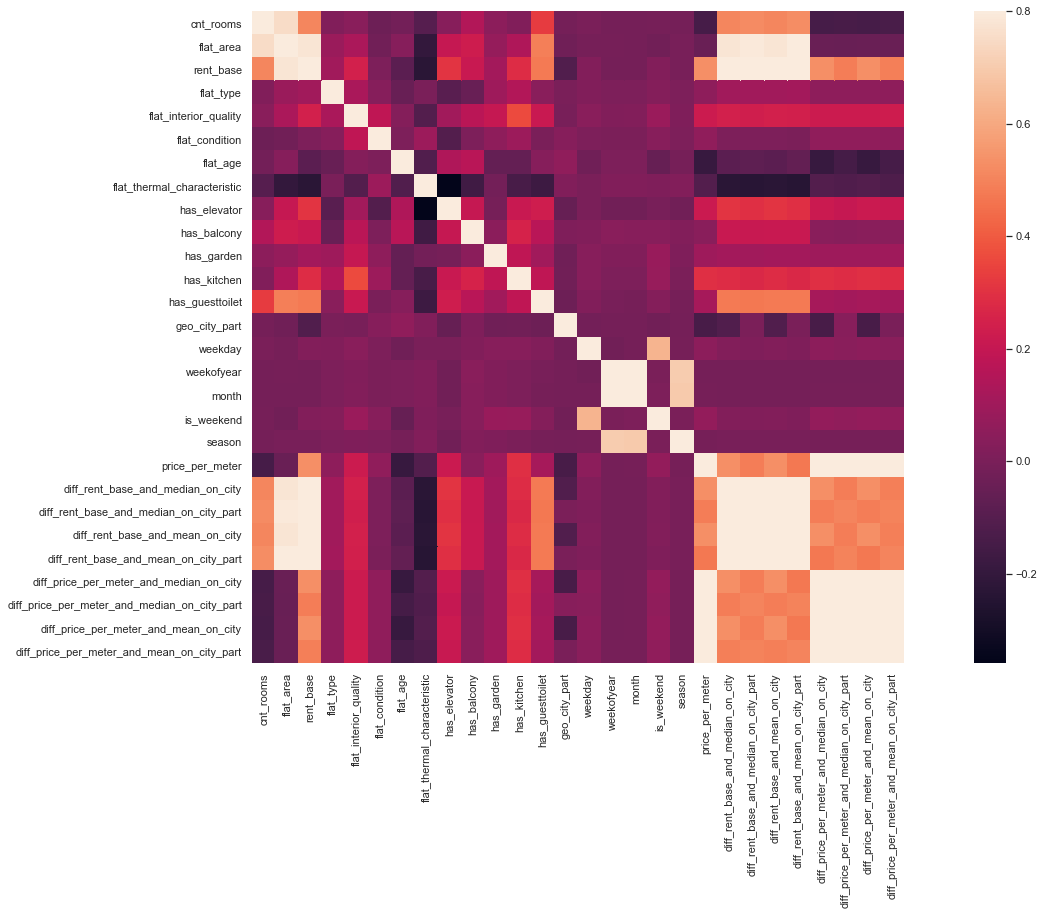

In [151]:
corrmatrix = prepared_df.corr()
f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(corrmatrix, vmax=.8, square=True)

## Naive LGBM with folds


In [152]:
prepared_df.head()

,cnt_rooms,flat_area,rent_base,flat_type,flat_interior_quality,flat_condition,flat_age,flat_thermal_characteristic,has_elevator,has_balcony,...,season,price_per_meter,diff_rent_base_and_median_on_city,diff_rent_base_and_median_on_city_part,diff_rent_base_and_mean_on_city,diff_rent_base_and_mean_on_city_part,diff_price_per_meter_and_median_on_city,diff_price_per_meter_and_median_on_city_part,diff_price_per_meter_and_mean_on_city,diff_price_per_meter_and_mean_on_city_part
0,1,36.00,530.0,0,0,2,0,138.3,0,1,...,4,14.722222,-203.48,-175.0,-300.266037,-235.197589,2.722222,3.801142,2.270438,3.503997
1,2,70.00,1100.0,0,0,2,0,138.3,1,1,...,4,15.714286,366.52,390.5,269.733963,249.569464,3.714286,3.230536,3.262502,2.755372
2,2,62.13,1040.0,0,4,0,6,50.7,1,1,...,4,16.739095,306.52,181.0,209.733963,99.218124,4.739095,3.277557,4.287312,3.459849
3,2,75.00,675.0,7,0,2,4,104.0,0,1,...,4,9.000000,-58.48,-30.0,-155.266037,-90.197589,-3.000000,-1.921080,-3.451784,-2.218225
4,2,52.00,676.0,0,0,2,0,138.3,0,1,...,4,13.000000,-57.48,-119.0,-154.266037,-214.119940,1.000000,-0.416936,0.548216,-0.701492


In [153]:
import lightgbm as lgb

In [154]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from math import sqrt

In [254]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, KFold

In [156]:
folds = KFold(n_splits=5, shuffle=False, random_state=11)

folds_idx = [(train_idx, val_idx) 
             for train_idx, val_idx in folds.split(prepared_df, y=y)]


In [157]:
params = {'num_leaves': 10,
         'min_data_in_leaf': 8, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 1337}

In [158]:
from sklearn.linear_model import Ridge

In [166]:
test_preds = []
oof_preds = np.zeros(prepared_df.shape[0])
mean_squared_errors = []
rmses = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds_idx):
    train_x, train_y = prepared_df.loc[train_idx], y.loc[train_idx]
    valid_x, valid_y = prepared_df.loc[valid_idx], y.loc[valid_idx]
    
    num_boost_round=1000
    early_stopping_rounds=250
    
    d_train = lgb.Dataset(train_x, label=train_y)
    d_valid = lgb.Dataset(valid_x, label=valid_y)
    clf = lgb.train(params,
                    d_train,
                    valid_sets=[d_train, d_valid], 
                    valid_names=['train','valid'], 
                    num_boost_round=num_boost_round,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=200,
                   )
    ridge = Ridge()
    ridge.fit(train_x, train_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = prepared_df.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof_preds[valid_idx] = clf.predict(valid_x)
    rmses.append(sqrt(mean_squared_error(valid_y, oof_preds[valid_idx])))
    
    print('Fold %2d RMSE Ridge: %.6f' % (n_fold + 1, sqrt(mean_squared_error(valid_y, ridge.predict(valid_x)))))
    
    
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmses[-1]))
    print('Fold %2d RMSLE : %.6f' % (n_fold + 1, sqrt(mean_squared_log_error(valid_y, oof_preds[valid_idx]))))

    
print("\n", f"Mean RMSE:{np.mean(rmses)}")
print(f"std: {np.std(rmses)}")
print(f"OOF RMSLE:{sqrt(mean_squared_log_error(y, oof_preds))}")
print(f"OOF RMSE:{sqrt(mean_squared_error(y, oof_preds))}")

Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 168.827	valid's rmse: 100.755
[400]	train's rmse: 135.05	valid's rmse: 72.115
[600]	train's rmse: 123.937	valid's rmse: 70.754
[800]	train's rmse: 116.015	valid's rmse: 70.7031
Early stopping, best iteration is:
[719]	train's rmse: 119.363	valid's rmse: 70.3625
Fold  1 RMSE Ridge: 68.240784
Fold  1 RMSE : 70.362538
Fold  1 RMSLE : 0.092184
Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 106.241	valid's rmse: 292.365
[400]	train's rmse: 73.4632	valid's rmse: 282.439
[600]	train's rmse: 68.2023	valid's rmse: 281.807
[800]	train's rmse: 65.5	valid's rmse: 281.571
[1000]	train's rmse: 63.6724	valid's rmse: 281.402
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 63.6724	valid's rmse: 281.402
Fold  2 RMSE Ridge: 281.860866
Fold  2 RMSE : 281.401656
Fold  2 RMSLE : 0.268588
Training until validation scores don't improve for 250 rounds.
[200]	train's rmse: 

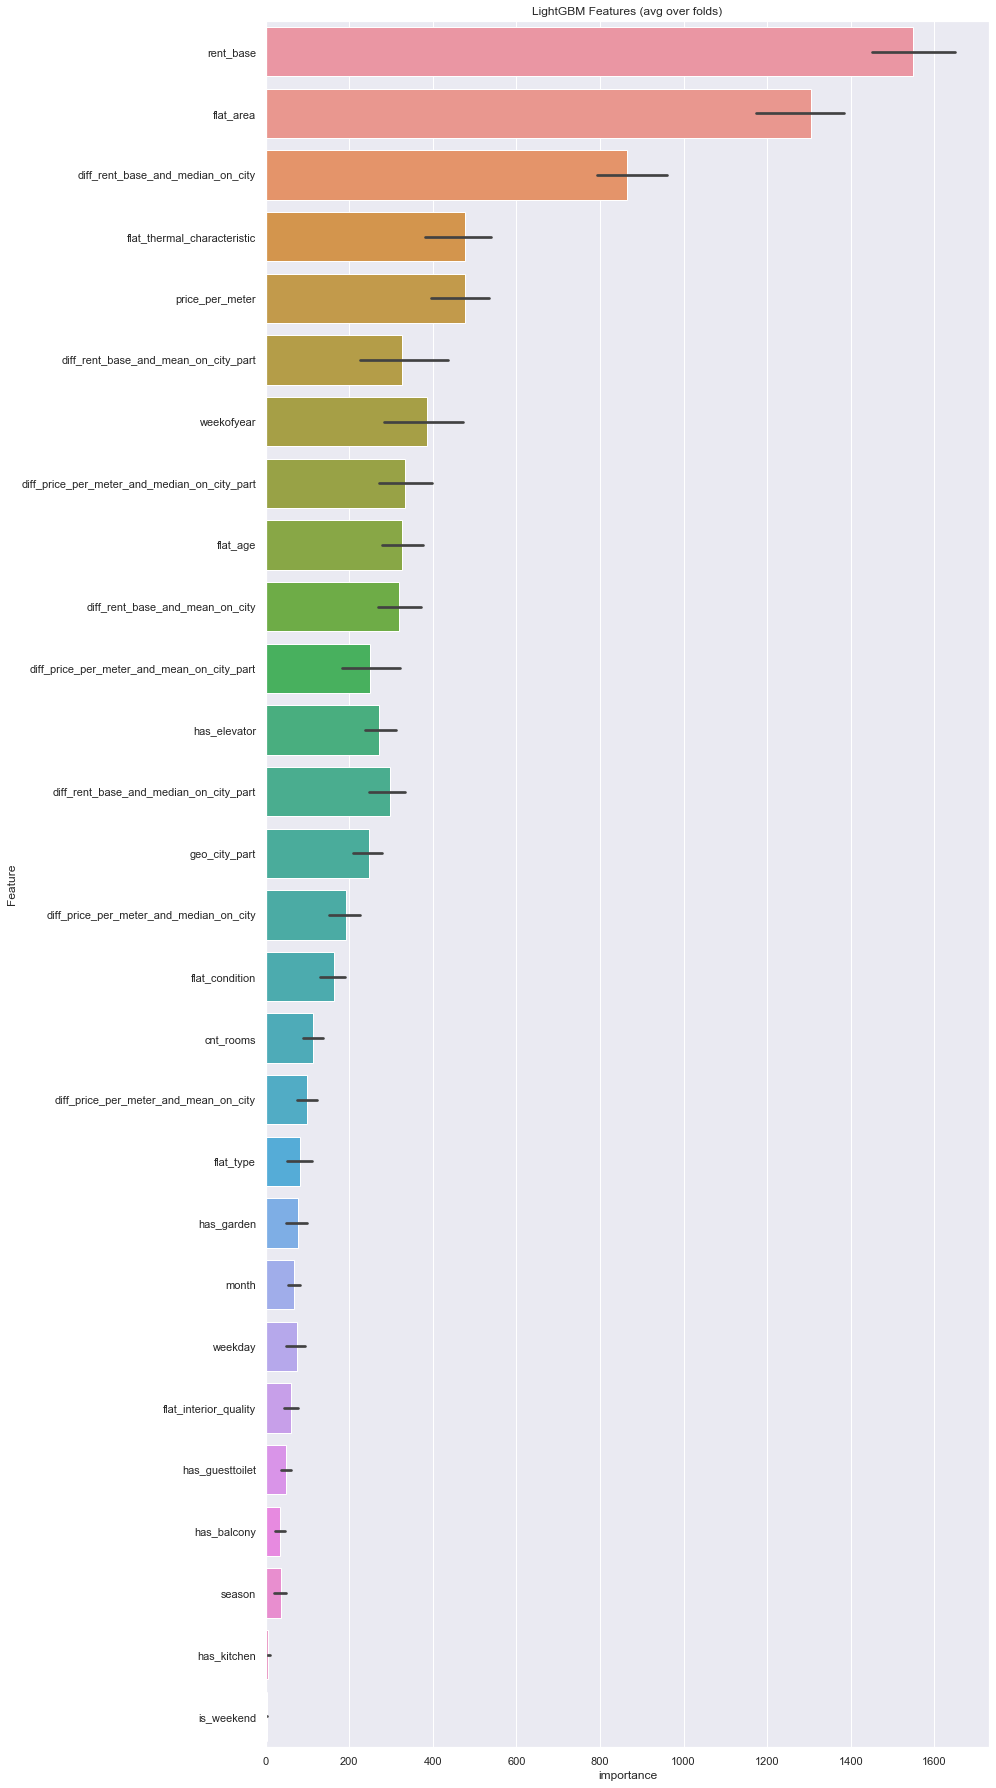

In [167]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

## Ok, let's try to see the data again

In [624]:
data = pd.read_csv('ml_eng_ay_data.csv')
data.flat_type.replace("appartment", "apartment", inplace=True)

In [625]:
data['date'] = pd.to_datetime(data.date)

data['weekday'] = data.date.dt.weekday
data['weekofyear'] = data.date.dt.weekofyear
data['month'] = data.date.dt.month
# data['is_weekend'] = data.weekday.isin((5,6))
data['season'] = data.month.apply(lambda dt: (dt %12 + 3)//3)

In [626]:
data['dayofyear'] = data.date.dt.dayofyear

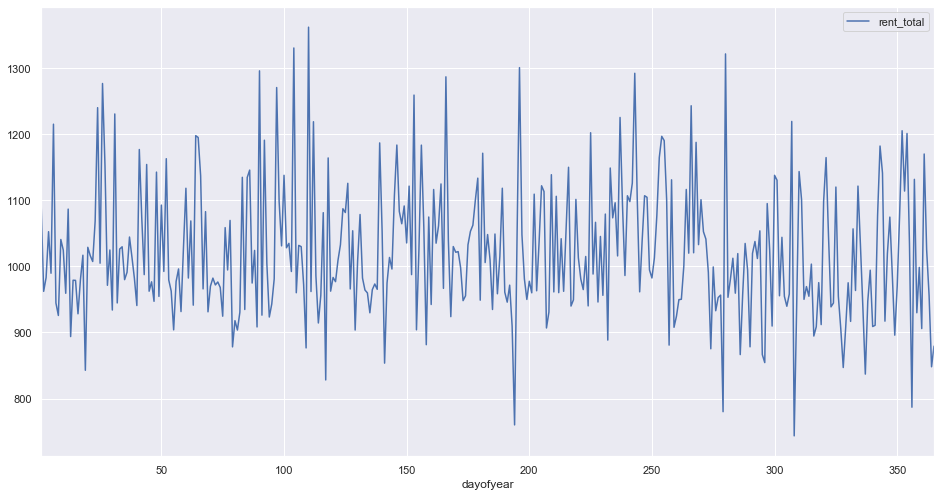

In [627]:
data[['rent_total', 'dayofyear']].groupby('dayofyear').mean().plot()

In [628]:
data['geo_city_part'].value_counts()

hamburg-nord    3349
wandsbek        2995
mitte           2312
eimsbuettel     2302
altona          1887
harburg         1341
bergedorf        774
Name: geo_city_part, dtype: int64

In [629]:
data['flat_type'].value_counts()

apartment              10681
ground_floor            1652
roof_storey             1353
raised_ground_floor      386
maisonette               320
terraced_flat            235
penthouse                222
half_basement             70
loft                      41
Name: flat_type, dtype: int64

## We can drop some useless columns, that can not get some information for us

In [630]:
data.drop(['date', 'flat_thermal_characteristic', 'geo_city', 'season'], axis=1, inplace=True)

In [631]:
data['flat_area'] = data['flat_area'].astype(int) 

## Return log rent_total for checking some distribution

In [632]:
data['log_rent_total'] = np.log1p(data.rent_total)

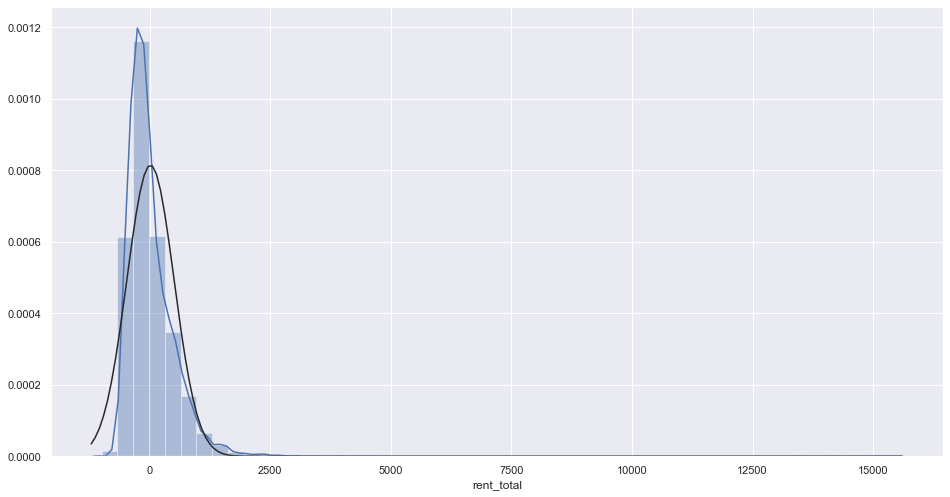

In [633]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(data['rent_total']-1000, fit=norm)

In [634]:
data['rent_total'].describe()

count    14960.000000
mean      1014.962983
std        489.487467
min          0.000000
25%        695.000000
50%        899.025000
75%       1220.000000
max      16401.000000
Name: rent_total, dtype: float64

Hm, so interesting

In [635]:
data = data[(data['rent_total'] < 2500) & (data['rent_total'] > 0)]

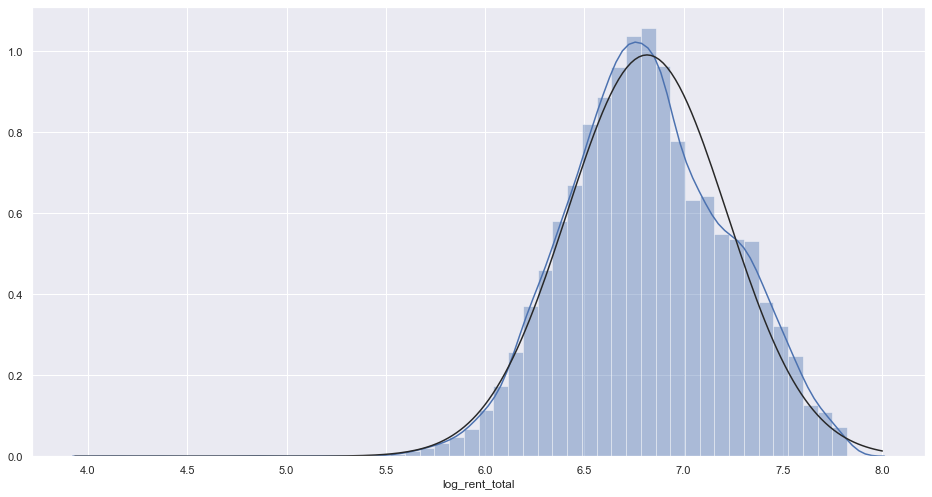

In [636]:
sns.set(rc={'figure.figsize':(16,8.27)})

sns.distplot(data['log_rent_total'], fit=norm)

#### We delete some outliers and now have more closer to normal distribution

In [637]:
ordinal_features = ['flat_interior_quality', 'flat_condition', 'flat_age']

In [638]:
data.dtypes

cnt_rooms                  int64
flat_area                  int64
rent_base                float64
rent_total               float64
flat_type                 object
flat_interior_quality     object
flat_condition            object
flat_age                  object
has_elevator              object
has_balcony               object
has_garden                object
has_kitchen               object
has_guesttoilet           object
geo_city_part             object
weekday                    int64
weekofyear                 int64
month                      int64
dayofyear                  int64
log_rent_total           float64
dtype: object

In [639]:
target_like_cols = ['rent_base', 'rent_total', 'log_rent_total']
X = data[[col for col in data.columns if col not in target_like_cols]].copy()
Y = data['log_rent_total'].copy() # We will fit&predict on logarifmic rent price

## Now we can try one-hot encoding for categorial features

In [640]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33,
                                                    stratify=X[['geo_city_part']],
                                                    random_state = 42)
X_train[to_normalize] = scaler.fit_transform(X_train[to_normalize]).copy()
X_test[to_normalize] = scaler.transform(X_test[to_normalize]).copy()

### Split data stratified to geo_city_part

for col in X_train.select_dtypes(['object']).columns:
    X_train[col] = X_train[col].astype('category')
X_train['cnt_rooms'] = X_train['cnt_rooms'].astype('category')
X_train = pd.get_dummies(X_train)

for col in X_test.select_dtypes(['object']).columns:
    X_test[col] = X_test[col].astype('category')
X_test['cnt_rooms'] = X_test['cnt_rooms'].astype('category')
X_test = pd.get_dummies(X_test)

In [641]:
X_train.shape

(9886, 55)

In [642]:
X_test.shape

(4870, 55)

In [643]:
to_normalize = ['dayofyear', 'month', 'weekofyear', 'flat_area']

In [644]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

In [645]:
import warnings
warnings.filterwarnings('ignore')

In [646]:
X_train.describe()

,flat_area,weekday,weekofyear,month,dayofyear,cnt_rooms_1,cnt_rooms_2,cnt_rooms_3,cnt_rooms_4,flat_type_apartment,...,has_kitchen_t,has_guesttoilet_f,has_guesttoilet_t,geo_city_part_altona,geo_city_part_bergedorf,geo_city_part_eimsbuettel,geo_city_part_hamburg-nord,geo_city_part_harburg,geo_city_part_mitte,geo_city_part_wandsbek
count,9.886000e+03,9886.000000,9.886000e+03,9.886000e+03,9.886000e+03,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,...,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000,9886.000000
mean,2.655731e-16,2.448108,3.134487e-16,5.592667e-18,-1.130992e-17,0.112482,0.406737,0.384483,0.096298,0.718794,...,0.672567,0.881044,0.118956,0.126037,0.052498,0.153348,0.223548,0.090633,0.151831,0.202104
std,1.000051e+00,1.751215,1.000051e+00,1.000051e+00,1.000051e+00,0.315975,0.491250,0.486497,0.295014,0.449610,...,0.469300,0.323753,0.323753,0.331908,0.223041,0.360341,0.416644,0.287101,0.358875,0.401590
min,-2.371937e+00,0.000000,-1.610922e+00,-1.503412e+00,-1.623278e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.550442e-01,1.000000,-8.839742e-01,-9.294060e-01,-9.081577e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.274664e-02,2.000000,-2.485417e-02,-6.839760e-02,-4.248543e-02,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.775967e-01,4.000000,9.003520e-01,7.926109e-01,9.078721e-01,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.225053e+00,6.000000,1.759472e+00,1.653619e+00,1.801773e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [647]:
ridge = Ridge(alpha=0.01, normalize=True, random_state=22)
ridge.fit(X_train, Y_train)
RMSLE = np.sqrt(mean_squared_error(Y_test, ridge.predict(X_test)))

In [648]:
RMSLE

0.1927176253982369

In [649]:
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(ridge.predict(X_test)))) # RMSE

206.5176570096431

In [511]:
# So huge too!

In [650]:
new_params = {'num_leaves': 15,
         'min_data_in_leaf': 8, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.08,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 228}

In [ ]:
## Try to fi

In [651]:
d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_test, label=Y_test)
clf = lgb.train(new_params,
                d_train,
                valid_sets=[d_train, d_valid], 
                valid_names=['train','valid'], 
                num_boost_round=10000,
                early_stopping_rounds=500,
                verbose_eval=200,
               )

Training until validation scores don't improve for 500 rounds.
[200]	train's rmse: 0.163261	valid's rmse: 0.177447
[400]	train's rmse: 0.150523	valid's rmse: 0.175635
[600]	train's rmse: 0.14083	valid's rmse: 0.175597
[800]	train's rmse: 0.132953	valid's rmse: 0.175757
Early stopping, best iteration is:
[498]	train's rmse: 0.145562	valid's rmse: 0.175435


In [652]:
lgb_pred = clf.predict(X_test)
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(lgb_pred))) # RMSE

172.56049391058178

In [707]:
# BETTER (but very awful)

## Check some diff between target and prediction

In [654]:
target_data = pd.DataFrame(Y_test)
target_data['rent_total'] = np.expm1(target_data.log_rent_total)
target_data['pred'] = np.expm1(lgb_pred)

In [655]:
target_data.head()

,log_rent_total,rent_total,pred
6559,6.734592,840.00,832.214856
9971,6.952729,1045.00,1020.927261
5987,7.380879,1604.00,1296.587576
3287,6.240276,512.00,573.532083
14374,6.461124,638.78,620.882133


In [656]:
target_data['diff'] = target_data['rent_total'] - target_data['pred']

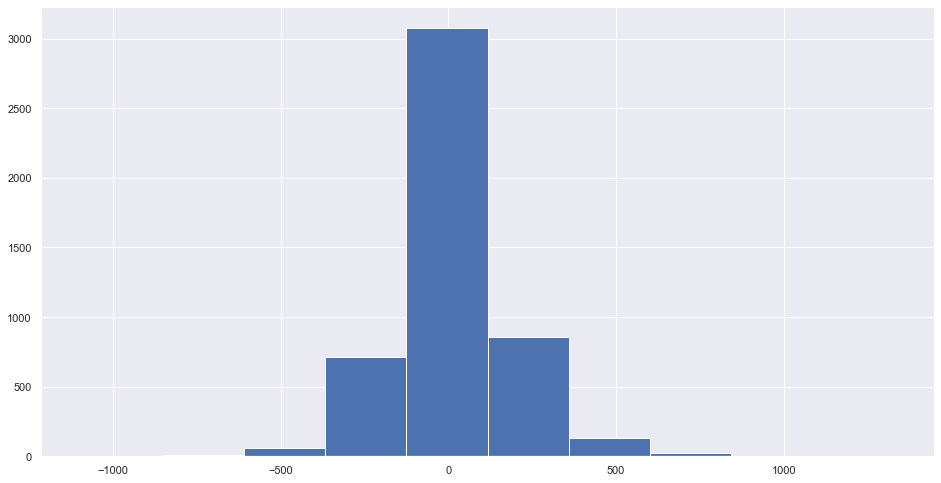

In [657]:
target_data['diff'].hist()

In [658]:
target_data['diff'].describe()

count    4870.000000
mean       13.021401
std       172.086164
min     -1092.289653
25%       -78.716876
50%         4.381892
75%        94.647847
max      1326.731500
Name: diff, dtype: float64

What we can see:
Median is so low (it's cool and good news for us, also 75% percentile +- good)
but then strong deviations "rock" our prediction

## Check by eyes where was the biggest error

In [659]:
target_data.loc[target_data['diff'] < -1000]

,log_rent_total,rent_total,pred,diff
3953,7.048386,1150.0,2155.779214,-1005.779214
5282,6.111467,450.0,1542.289653,-1092.289653


In [549]:
data.loc[data.index==5282]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
5282,4,98,300.0,450.0,roof_storey,average,good,60+,f,f,f,t,f,hamburg-nord,0,4,1,21,6.111467


In [660]:
data.loc[data.index==3953]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
3953,3,110,950.0,1150.0,roof_storey,sophisticated,mint_condition,<5,f,f,f,f,f,mitte,5,50,12,349,7.048386


## Hm, so strange

In [661]:
data.loc[data.index.isin(target_data.loc[target_data['diff'] > 500].index)]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
434,4,101,1690.00,2190.0,apartment,average,first_time_use,<5,t,f,f,f,f,altona,1,39,9,268,7.692113
531,3,67,1250.00,1550.0,terraced_flat,normal,good,60+,f,t,t,t,f,hamburg-nord,3,39,9,270,7.346655
978,2,47,1200.00,1400.0,apartment,average,renovated,<50,t,t,f,t,f,altona,1,41,10,282,7.244942
1343,2,102,1950.00,2190.0,apartment,average,good,<20,t,f,f,t,f,mitte,2,42,10,290,7.692113
1639,3,65,1500.00,1650.0,ground_floor,average,good,60+,f,t,t,t,f,eimsbuettel,1,43,10,296,7.409136
1730,4,104,2450.00,2450.0,maisonette,sophisticated,renovated,60+,f,f,t,t,t,altona,3,43,10,298,7.804251
2212,4,110,2100.00,2300.0,ground_floor,sophisticated,renovated,60+,f,t,t,t,t,hamburg-nord,1,45,11,310,7.741099
2287,2,64,1125.00,1400.0,apartment,average,good,60+,f,f,f,f,f,altona,3,45,11,312,7.244942
2949,4,80,1500.00,1850.0,apartment,average,good,60+,f,t,f,t,f,eimsbuettel,2,47,11,325,7.523481
4097,3,61,1750.00,1950.0,apartment,sophisticated,renovated,60+,f,f,f,t,f,altona,3,51,12,354,7.576097


## Try to return to features rent_base?

In [662]:
X = data[[col for col in data.columns if col not in ['rent_total', 'log_rent_total']]].copy()

X['log_rent_base'] = np.log1p(X['rent_base'])
X.drop(columns=['rent_base'], axis=1, inplace=True)
Y = data['log_rent_total'].copy()


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33,
                                                    stratify=X[['geo_city_part']],
                                                    random_state = 42)
scaler = StandardScaler()
X_train[to_normalize] = scaler.fit_transform(X_train[to_normalize]).copy()
X_test[to_normalize] = scaler.transform(X_test[to_normalize]).copy()

### Split data stratified to geo_city_part

for col in X_train.select_dtypes(['object']).columns:
    X_train[col] = X_train[col].astype('category')
X_train['cnt_rooms'] = X_train['cnt_rooms'].astype('category')
X_train = pd.get_dummies(X_train)

for col in X_test.select_dtypes(['object']).columns:
    X_test[col] = X_test[col].astype('category')
X_test['cnt_rooms'] = X_test['cnt_rooms'].astype('category')
X_test = pd.get_dummies(X_test)

In [663]:
ridge = Ridge(alpha=0.01, normalize=True, random_state=22)
ridge.fit(X_train, Y_train)
RMSLE = np.sqrt(mean_squared_error(Y_test, ridge.predict(X_test)))

In [664]:
RMSLE

0.08098556528881501

In [665]:
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(ridge.predict(X_test)))) # RMSE

64.31079184731037

# OH. MY. GOD.

In [666]:
d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_test, label=Y_test)
clf = lgb.train(new_params,
                d_train,
                valid_sets=[d_train, d_valid], 
                valid_names=['train','valid'], 
                num_boost_round=10000,
                early_stopping_rounds=500,
                verbose_eval=200,
               )

Training until validation scores don't improve for 500 rounds.
[200]	train's rmse: 0.0612554	valid's rmse: 0.0653903
[400]	train's rmse: 0.0553875	valid's rmse: 0.0655319
[600]	train's rmse: 0.0509586	valid's rmse: 0.0659617
Early stopping, best iteration is:
[259]	train's rmse: 0.0592373	valid's rmse: 0.0652965


In [667]:
lgb_pred = clf.predict(X_test)
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(lgb_pred))) # RMSE

57.63055135036555

## Check mistakes again

In [668]:
target_data = pd.DataFrame(Y_test)
target_data['rent_total'] = np.expm1(target_data.log_rent_total)
target_data['pred'] = np.expm1(lgb_pred)
target_data['diff'] = target_data['rent_total'] - target_data['pred']

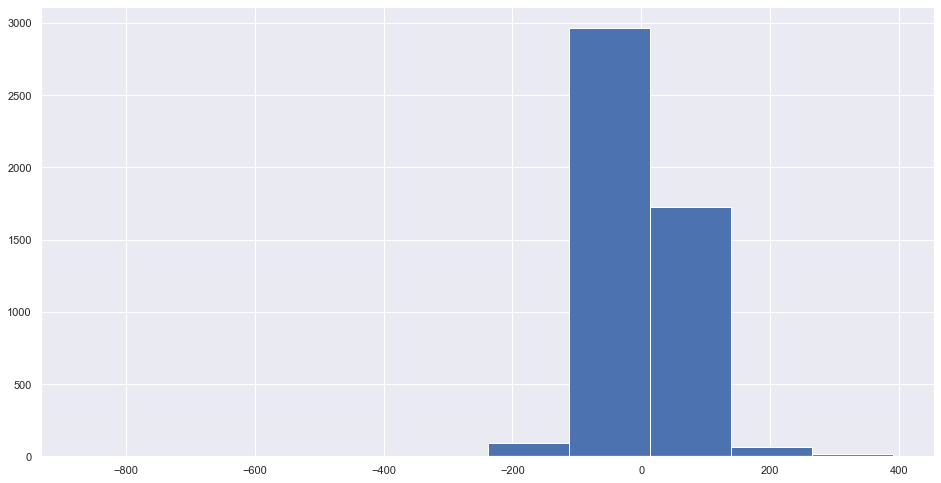

In [669]:
target_data['diff'].hist()

In [670]:
target_data['diff'].describe()

count    4870.000000
mean        2.293558
std        57.590807
min      -868.462093
25%       -26.768507
50%         0.028282
75%        29.350823
max       391.708375
Name: diff, dtype: float64

# We fixed our mistakes in several times! Let's check the examples with wrong prediction again

In [672]:
data.loc[data.index.isin(target_data.loc[target_data['diff'] > 380].index)]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
10659,2,64,10.75,843.0,apartment,normal,good,<50,t,t,f,t,f,wandsbek,1,21,5,141,6.738152


In [673]:
data.loc[data.index.isin(target_data.loc[target_data['diff'] < -500].index)]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
5270,3,84,830.0,165.0,apartment,normal,good,<50,f,t,f,t,f,wandsbek,0,4,1,21,5.111988


# wow it's real outliers lol, because we have noise data

### Let's check all the data before splitting

In [674]:
data.loc[data.rent_base - data.rent_total > 100]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
39,1,49,864.85,120.26,apartment,sophisticated,good,60+,f,f,t,t,f,altona,0,38,9,260,4.797937
613,2,60,800.00,130.00,apartment,normal,renovated,60+,t,t,f,t,f,hamburg-nord,5,39,9,272,4.875197
2106,2,44,695.00,75.00,apartment,average,good,60+,f,f,f,f,f,eimsbuettel,0,45,11,309,4.330733
5270,3,84,830.00,165.00,apartment,normal,good,<50,f,t,f,t,f,wandsbek,0,4,1,21,5.111988
5288,1,33,990.00,790.00,apartment,normal,good,<60,t,t,f,t,f,altona,1,4,1,22,6.673298
6427,2,63,8950.00,1132.00,apartment,average,mint_condition,<10,t,t,f,t,f,eimsbuettel,4,7,2,46,7.032624
11811,2,71,898.38,635.22,apartment,sophisticated,first_time_use,<1,f,t,t,t,f,mitte,3,25,6,171,6.455544
14086,1,49,1082.90,886.90,apartment,sophisticated,good,60+,f,f,t,t,f,altona,3,34,8,234,6.788859


### Drop all of them, cause i think it's smth strange and not really information

In [677]:
data.loc[data.rent_total / data.rent_base > 2.5]

,cnt_rooms,flat_area,rent_base,rent_total,flat_type,flat_interior_quality,flat_condition,flat_age,has_elevator,has_balcony,has_garden,has_kitchen,has_guesttoilet,geo_city_part,weekday,weekofyear,month,dayofyear,log_rent_total
1443,1,30,159.82,399.82,apartment,average,good,<50,f,f,f,t,f,wandsbek,4,42,10,292,5.993512
5322,4,104,117.99,1552.99,apartment,sophisticated,good,<30,t,t,f,t,t,altona,1,4,1,22,7.348581
10659,2,64,10.75,843.00,apartment,normal,good,<50,t,t,f,t,f,wandsbek,1,21,5,141,6.738152
14335,2,54,816.75,2450.25,apartment,average,good,<1,f,f,f,f,f,wandsbek,3,35,8,241,7.804353


In [676]:
# Oh, it's really interesting. We can see some duplicates in this

In [679]:
drop_indexes = []
drop_indexes.extend(data.loc[data.rent_base - data.rent_total > 100].index)
drop_indexes.extend(data.loc[data.rent_total / data.rent_base > 2.5].index)

In [680]:
len(drop_indexes)

12

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [709]:
X = data[[col for col in data.columns if col not in ['rent_total', 'log_rent_total']]].copy()

X = X.loc[~X.index.isin(drop_indexes)]
scaler = StandardScaler()
X[to_normalize] = scaler.fit_transform(X[to_normalize]).copy()


X['log_rent_base'] = np.log1p(X['rent_base'])
X.drop(columns=['rent_base'], axis=1, inplace=True)
Y = data['log_rent_total'].copy()
Y = Y.loc[~Y.index.isin(drop_indexes)]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33,
                                                    stratify=X[['geo_city_part', 'month']],
                                                    random_state = 42)
# scaler = StandardScaler()
# X_train[to_normalize] = scaler.fit_transform(X_train[to_normalize]).copy()
# X_test[to_normalize] = scaler.transform(X_test[to_normalize]).copy()

### Split data stratified to geo_city_part

for col in X_train.select_dtypes(['object']).columns:
    X_train[col] = X_train[col].astype('category')
X_train['cnt_rooms'] = X_train['cnt_rooms'].astype('category')
X_train = pd.get_dummies(X_train)

for col in X_test.select_dtypes(['object']).columns:
    X_test[col] = X_test[col].astype('category')
X_test['cnt_rooms'] = X_test['cnt_rooms'].astype('category')
X_test = pd.get_dummies(X_test)

In [710]:
ridge = Ridge(alpha=0.01, normalize=True, random_state=22)
ridge.fit(X_train, Y_train)
RMSLE = np.sqrt(mean_squared_error(Y_test, ridge.predict(X_test)))

In [711]:
RMSLE

0.0614492656060273

In [712]:
new_params = {'num_leaves': 20,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.001,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 42}

In [697]:
d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_test, label=Y_test)
clf = lgb.train(new_params,
                d_train,
                valid_sets=[d_train, d_valid], 
                valid_names=['train','valid'], 
                num_boost_round=30000,
                early_stopping_rounds=500,
                verbose_eval=5000,
               )
lgb_pred = clf.predict(X_test)
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(lgb_pred))) 

Training until validation scores don't improve for 500 rounds.
[5000]	train's rmse: 0.0588964	valid's rmse: 0.059277
[10000]	train's rmse: 0.0538183	valid's rmse: 0.056464
[15000]	train's rmse: 0.0514045	valid's rmse: 0.0558721
[20000]	train's rmse: 0.049562	valid's rmse: 0.0556412
[25000]	train's rmse: 0.0479887	valid's rmse: 0.0555386
Early stopping, best iteration is:
[28720]	train's rmse: 0.0469364	valid's rmse: 0.0555087


53.01572428620435

## better

Let's check feature importances?

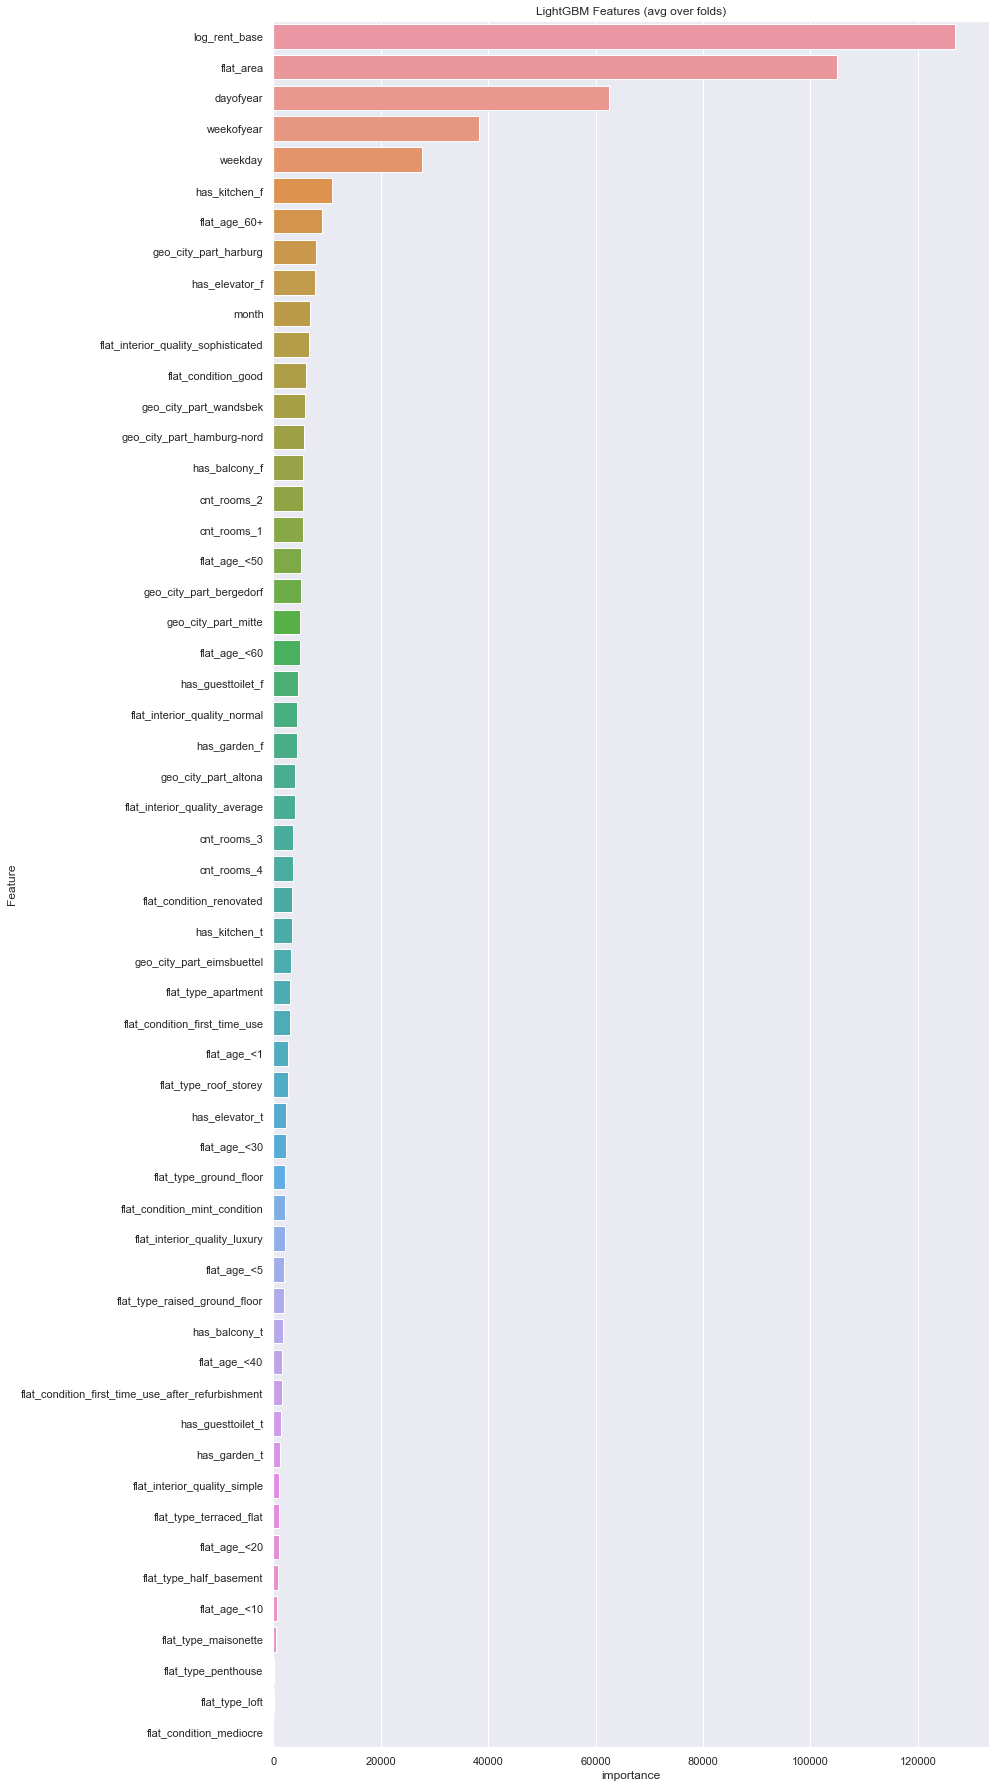

In [698]:
fold_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = X_train.columns
fold_importance_df["importance"] = clf.feature_importance()

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=fold_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# Yes, I have a feeling that this is a leak :(

I think it's enough for this time, let's try to save this model for inference in service

# Prepare for inference

In [780]:
inf_params = {'num_leaves': 20,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.002,
         "min_child_samples": 5,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 42}

In [826]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1,
                                                    stratify=X[['geo_city_part', 'month']],
                                                    random_state = 42)

for col in X_train.select_dtypes(['object']).columns:
    X_train[col] = X_train[col].astype('category')
X_train['cnt_rooms'] = X_train['cnt_rooms'].astype('category')
X_train['weekday'] = X_train['weekday'].astype('category')


X_train = pd.get_dummies(X_train)

for col in X_test.select_dtypes(['object']).columns:
    X_test[col] = X_test[col].astype('category')
X_test['cnt_rooms'] = X_test['cnt_rooms'].astype('category')
X_test['weekday'] = X_test['weekday'].astype('category')


X_test = pd.get_dummies(X_test)
d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_test, label=Y_test)
clf = lgb.train(inf_params,
                d_train,
                valid_sets=[d_train, d_valid], 
                valid_names=['train','valid'], 
                num_boost_round=40000,
                early_stopping_rounds=500,
                verbose_eval=5000,
               )
lgb_pred = clf.predict(X_test)
np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(lgb_pred))) 

Training until validation scores don't improve for 500 rounds.
[5000]	train's rmse: 0.0533245	valid's rmse: 0.0676876
[10000]	train's rmse: 0.0497675	valid's rmse: 0.0664241
[15000]	train's rmse: 0.0472651	valid's rmse: 0.0661688
Early stopping, best iteration is:
[18618]	train's rmse: 0.0457153	valid's rmse: 0.0660928


56.72856842231336

In [831]:
X_train.shape, X_test.shape

((13269, 62), (1475, 62))

In [827]:
from sklearn.externals import joblib

joblib.dump(clf, 'lgbm.pkl')

['lgbm_new.pkl']

In [841]:
scaler.fit(data[to_normalize])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [842]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [836]:
X_train.columns

Index(['flat_area', 'weekofyear', 'month', 'dayofyear', 'log_rent_base',
       'cnt_rooms_1', 'cnt_rooms_2', 'cnt_rooms_3', 'cnt_rooms_4',
       'flat_type_apartment', 'flat_type_ground_floor',
       'flat_type_half_basement', 'flat_type_loft', 'flat_type_maisonette',
       'flat_type_penthouse', 'flat_type_raised_ground_floor',
       'flat_type_roof_storey', 'flat_type_terraced_flat',
       'flat_interior_quality_average', 'flat_interior_quality_luxury',
       'flat_interior_quality_normal', 'flat_interior_quality_simple',
       'flat_interior_quality_sophisticated', 'flat_condition_first_time_use',
       'flat_condition_first_time_use_after_refurbishment',
       'flat_condition_good', 'flat_condition_mediocre',
       'flat_condition_mint_condition', 'flat_condition_renovated',
       'flat_age_60+', 'flat_age_<1', 'flat_age_<10', 'flat_age_<20',
       'flat_age_<30', 'flat_age_<40', 'flat_age_<5', 'flat_age_<50',
       'flat_age_<60', 'has_elevator_f', 'has_elevator_t', 

In [814]:
X.select_dtypes(['object']).columns

Index(['flat_type', 'flat_interior_quality', 'flat_condition', 'flat_age',
       'has_elevator', 'has_balcony', 'has_garden', 'has_kitchen',
       'has_guesttoilet', 'geo_city_part'],
      dtype='object')

### the end


but maybe to be continied...

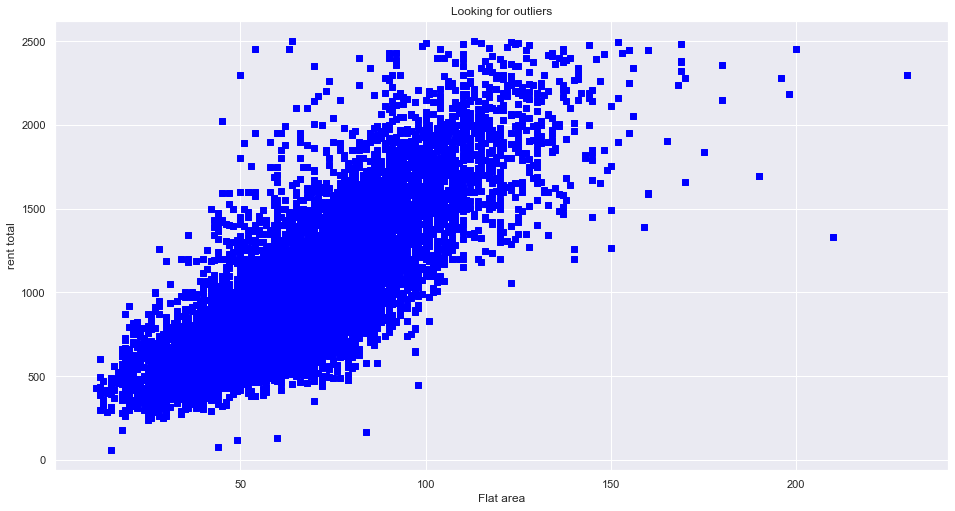

In [569]:
plt.scatter(data.flat_area, data.rent_total, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("Flat area")
plt.ylabel("rent total")
plt.show()